In [21]:
import sys
sys.path.append("models/")
from setup import out_dir, data_dir, image_dir, model_dir, streetview_dir, proj_dir
%load_ext autoreload
%autoreload 2

import os
from datetime import datetime
import json
from collections import OrderedDict
import logging
import argparse
import numpy as np
import random
import matplotlib.pyplot as plt
import glob
import pandas as pd
import pickle as pkl

import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
import torch.backends.cudnn
import torchvision.utils
import torchvision.transforms
import torch.nn.functional as F

try:
    from tensorboardX import SummaryWriter
    is_tensorboard_available = True
except Exception:
    is_tensorboard_available = False

from dataloader import image_loader, load_demo
from autoencoder import Autoencoder
from M1_util_train_test import load_model, train, test, AverageMeter
from util_model import my_loss
from exp_version import get_hp_from_version_code

torch.backends.cudnn.benchmark = True

logging.basicConfig(
    format='[%(asctime)s %(name)s %(levelname)s] - %(message)s',
    datefmt='%Y/%m/%d %H:%M:%S',
    level=logging.DEBUG)
logger = logging.getLogger(__name__)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [27]:
from setup import model_dir, image_dir, out_dir, data_dir
from util_model import parse_args

zoomlevel = 'zoom15'
latent_dim = 64*2
# demo_cols = [0,1,2,3,4,8,9]
demo_cols = [0,9]
demo_dim = len(demo_cols)
image_size = str(64)
im_norm = '2'
model_run_date = "2210gan-2c0"
model_type = 'dcgan'
loss_func = 'cosh'
model_class = 'vae'
base_lr = '0.001'
weight_decay = '0'
sampling = 'clustered'

args = parse_args(s=['--zoomlevel', zoomlevel, '--latent_dim', str(latent_dim), 
                     '--image_size', image_size, \
                     '--im_norm', im_norm, '--model_run_date', model_run_date, '--model_type', model_type, \
                     '--loss_func', loss_func, '--model_class', model_class, \
                     '--base_lr', base_lr, '--weight_decay', weight_decay, \
                     '--demo_channels', str(demo_dim),
                     '--sampling', sampling])

from util_model import dcgan_config, load_model

config = dcgan_config(args)

encoder = load_model('dcgan', 'Discriminator', config)
decoder = load_model('dcgan', 'Generator', config)

config['encoder'] = encoder
config['decoder'] = decoder

model = load_model('vae','VAE', config)
model.to(device)
model.train();

# Check one model exists for this config
import glob
import torch

if loss_func == 'cosh':
    model_path = glob.glob(model_dir+"cosh/AE_"+zoomlevel+"_"+str(latent_dim)+"_"+str(image_size)+
                       "_"+str(int(im_norm))+"_"+str(model_run_date)+"_*.pt")
else:
    model_path = glob.glob(model_dir+"AE_"+zoomlevel+"_"+str(latent_dim)+"_"+str(image_size)+
                       "_"+str(int(im_norm))+"_"+str(model_run_date)+"_*.pt")

if len(model_path) == 1:
    saved = torch.load(model_path[0])
    print(model_path[0], "loaded.")
else:
    print("Error. More than one model or no model exists.")
    print(model_path)
    print(model_dir+"AE_"+zoomlevel+"_"+str(latent_dim)+"_"+str(image_size)+
                       "_"+str(int(im_norm))+"_"+str(model_run_date)+"_*.pt")

model.load_state_dict(saved['model_state_dict']);
model.eval();

In [28]:
model_name = datetime.now().strftime("%m%d-%H%M")

run_config = config['run_config']
optim_config = config['optim_config']
data_config = config['data_config']
model_config = config['model_config']

# TensorBoard SummaryWriter
# writer = SummaryWriter(model_name) if run_config['tensorboard'] else None

# set random seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [10]:
# MNIST
import torchvision.transforms as transforms

def setup_data_loaders(batch_size=optim_config['batch_size'], use_cuda=True):
    root = './data'
    download = False
    trans = transforms.ToTensor()
    train_set = MNIST(root=root, train=True, transform=trans,
                      download=download)
    test_set = MNIST(root=root, train=False, transform=trans)

    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

from pyro.contrib.examples.util import MNIST
train_loader, test_loader = setup_data_loaders()

In [6]:
# CelebA
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.datasets import CelebA

# train_set = datasets.CelebA(root="./", split="Train", download=True, transform=transforms.ToTensor())
# test_set = datasets.CelebA(root="./", split="Test", download=True, transform=transforms.ToTensor())

transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                              transforms.CenterCrop(148),
                                              transforms.Resize(data_config['image_size']),
                                              transforms.ToTensor(),])
        
train_dataset = CelebA(
    "./",
    split='train',
    transform=transforms,
    download=False,
)

test_dataset = CelebA(
    "./",
    split='test',
    transform=transforms,
    download=False,
)

train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=optim_config['batch_size'],
            num_workers=8,
            shuffle=True,
            pin_memory=True,
        )

test_loader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size=optim_config['batch_size'],
            num_workers=8,
            shuffle=True,
            pin_memory=True,
        )

In [5]:
# Satellite
train_loader, test_loader = image_loader(image_dir+args.zoomlevel+"/", data_dir, optim_config['batch_size'], 
         run_config['num_workers'], 
         data_config['image_size'], 
         data_version=args.data_version, 
         sampling=args.sampling, 
         recalculate_normalize=False,
         augment=False,
         norm=args.im_norm,
         demo=True)

28280 images in dataset
3140 images in dataset


In [6]:
# Streetview
model_run_date = '2209strt'
sampling = 'stratified'
data_version = '1571'


train_loader, test_loader = image_loader(streetview_dir, data_dir, 
                                         optim_config['batch_size'], 
                                         run_config['num_workers'], 
                                         data_config['image_size'], 
                                         data_version=data_version, 
                                         sampling=sampling, 
                                         recalculate_normalize=False,
                                         image_type='jpg')

In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=optim_config['base_lr'])
criterion = model.loss_function
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)

In [30]:
train_elbo = []
test_elbo = []
ref1 = 0
ref2 = 0


In [ ]:
# training loop
start_epoch = 0
train_flag = False

for epoch in range(start_epoch, start_epoch+optim_config['epochs']):
    # initialize loss accumulator
    train_loss = 0.0
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for step, (image_list, data, demo) in enumerate(train_loader):
#     for data, _ in train_loader:

        demo_conv = demo[:,demo_cols,None,None].expand(-1,-1,int(image_size),int(image_size)).to(device)

        # if on GPU put mini-batch into CUDA memory
        data = data.to(device)
        
        data_cat = torch.cat([data, demo_conv], 1)
        optimizer.zero_grad()
        
        # do ELBO gradient and accumulate loss
        x_, mu, log_var = model.forward(data_cat)
        loss = criterion(x_, data, mu, log_var)#, len(data)/len(train_loader.dataset))
        
        train_loss += loss['loss'].item()
        
        loss['loss'].backward()

        optimizer.step()
        
    scheduler.step()
    # report training diagnostics
    
    train_loss /= len(train_loader)
    train_elbo.append(train_loss)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, train_loss))

    if epoch % 5 == 0:
        # initialize loss accumulator
        test_loss = 0.0
        test_recon = 0.0
        test_kld = 0.0
        
        # compute the loss over the entire test set
        for step, (image_list, data, demo) in enumerate(test_loader):
#         for data,_ in test_loader:
            demo_conv = demo[:,demo_cols,None,None].expand(-1,-1,int(image_size),int(image_size)).to(device)
    
            # if on GPU put mini-batch into CUDA memory
            data = data.to(device)
            
            data_cat = torch.cat([data, demo_conv], 1)
            # compute ELBO estimate and accumulate loss
            x_, mu, log_var = model.forward(data_cat)
            loss = criterion(x_, data, mu, log_var)#, len(data)/len(train_loader.dataset))

            test_loss += loss['loss'].item()
            test_recon += loss['Reconstruction_Loss'].item()
            test_kld += loss['KLD'].item()
  
        # report test diagnostics
        test_loss /= len(test_loader)
        test_recon = test_recon / len(test_loader)/64/64/3
        test_kld /= len(test_loader)
        
        test_elbo.append(test_loss)
        print("[epoch %03d]  average test loss: %.4f" % (epoch, test_loss))
        
        print("recon loss:", test_recon, "KLD:", test_kld)
        
        if epoch > 30:
            if (np.abs(train_loss - ref1)/ref1<0.001) & (np.abs(train_loss - ref2)/ref2<0.001):
                print("Early stopping at epoch", epoch)
                train_flag = True
                break
            if (ref1 < train_loss) & (ref1 < ref2):
                print("Diverging. stop.")
                break
            if train_loss < best:
                best = train_loss
                best_epoch = epoch
                best_recon = test_recon
                best_kld = test_kld
        else:
            best = train_loss
            best_epoch = epoch
            best_recon = test_recon
            best_kld = test_kld

        ref2 = ref1
        ref1 = train_loss

        if (config['run_config']['save']) & (best_epoch==epoch):
            torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer,
                'config': config},
                model_dir+"cVAE_"+args.zoomlevel+"_"+str(model_config['latent_dim']//2)+"_"+\
                  str(args.image_size)+"_"+str(int(args.im_norm))+"_"+str(args.model_run_date)+\
                  "_"+args.loss_func+"_"+str(epoch)+".pt")

files = glob.glob(model_dir+"cVAE_"+args.zoomlevel+"_"+str(model_config['latent_dim']//2)+"_"+\
                      str(args.image_size)+"_"+str(int(args.im_norm))+"_"+str(args.model_run_date)+\
                      "_"+args.loss_func+"_*.pt")

if config['run_config']['save']:
    for f in files:
        e = int(f.split("_")[-1].split(".")[0])
        if e != best_epoch:
            os.remove(f)

with open(out_dir+"VAE.csv", "a") as f:
    f.write("%s,%s,%d,%d,%d,%.2E,%.2E,%d,%.4f,%.4f,%.4f,%d,%s\n" % \
            (args.model_run_date, args.zoomlevel, model_config['latent_dim']//2, args.image_size, args.im_norm, 
             args.base_lr, args.weight_decay, best_epoch, best, best_recon, best_kld, train_flag, args.loss_func))

[epoch 000]  average training loss: 549998656.8079
[epoch 000]  average test loss: 633.2774
recon loss: 0.04718481029073398 KLD: 53.47043243408203
[epoch 001]  average training loss: 516.9085
[epoch 002]  average training loss: 508.8856
[epoch 003]  average training loss: 503.4574
[epoch 004]  average training loss: 499.3188
[epoch 005]  average training loss: 503.0268
[epoch 005]  average test loss: 620.5918
recon loss: 0.04407098521788915 KLD: 79.04749694824218
[epoch 006]  average training loss: 512.5488
[epoch 007]  average training loss: 504.0806
[epoch 008]  average training loss: 501.5114
[epoch 009]  average training loss: 497.8191
[epoch 010]  average training loss: 491.6785
[epoch 010]  average test loss: 585.3717
recon loss: 0.042426683654387794 KLD: 64.03258964538574
[epoch 011]  average training loss: 488.6251
[epoch 012]  average training loss: 486.8395
[epoch 013]  average training loss: 483.5639
[epoch 014]  average training loss: 482.7559
[epoch 015]  average training 

In [9]:
# Save Embeddings

ct = []
encoder_output = []
im = []

for step, (image_list, data, demo) in enumerate(train_loader):
    data = data.to(device)
    demo_conv = demo[:,demo_cols,None,None].expand(-1,-1,int(image_size),int(image_size)).to(device)
    data_cat = torch.cat([data, demo_conv], 1)
    
    ct += [s[s.rindex("/")+1: s.rindex("_")]for s in image_list]
    encoder_output += [model.encode(data_cat).cpu().detach().numpy()]
    im += image_list
    if step % 10 == 0:
        print(step, end='\t')
encoder_output = np.vstack(encoder_output)    
encoder_output = encoder_output.reshape(len(encoder_output), -1)
       
test_ct = []
test_encoder_output = []
test_im = []

for step, (image_list, data, demo) in enumerate(test_loader):
    data = data.to(device)
    demo_conv = demo[:,demo_cols,None,None].expand(-1,-1,int(image_size),int(image_size)).to(device)
    data_cat = torch.cat([data, demo_conv], 1)
    
    
    test_ct += [s[s.rindex("/")+1: s.rindex("_")]for s in image_list]
    test_encoder_output += [model.encode(data_cat).cpu().detach().numpy()]
    test_im += image_list
    if step % 10 == 0:
        print(step, end='\t')
        
test_encoder_output = np.vstack(test_encoder_output)    
test_encoder_output = test_encoder_output.reshape(len(test_encoder_output), -1)

with open(proj_dir+"latent_space/cVAE_"+args.zoomlevel+"_"+str(model_config['latent_dim']//2)+"_"+\
                      str(args.image_size)+"_"+str(int(args.im_norm))+"_"+str(args.model_run_date)+\
                      "_"+args.loss_func+".pkl", "wb") as f:
    pkl.dump(encoder_output, f)
    pkl.dump(im, f)
    pkl.dump(ct, f)
    pkl.dump(test_encoder_output, f)
    pkl.dump(test_im, f)
    pkl.dump(test_ct, f)

0	10	20	30	40	50	60	70	80	90	100	110	120	130	140	150	160	170	180	190	200	210	220	230	240	250	260	270	280	290	300	310	320	330	340	350	360	370	380	390	400	410	420	430	440	0	10	20	30	40	

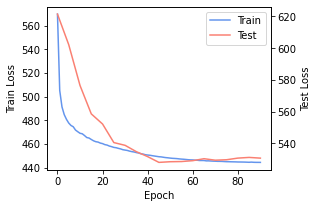

In [11]:
fig, ax = plt.subplots(1, figsize=(4,3))
ln1 = ax.plot(train_elbo, label='Train', color='cornflowerblue')
ax2 = ax.twinx()
ln2 = ax2.plot(np.arange(0, epoch+1, 5), test_elbo, label='Test', color='salmon')

lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

ax.set_xlabel("Epoch")
ax.set_ylabel("Train Loss")
ax2.set_ylabel("Test Loss")
# fig.savefig(out_dir+"training_plots/"+model_type+"_"+zoomlevel+"_"+str(latent_dim)+"_"+
#                 model_save_variable_names[y]+"_"+model_run_date+".png", bbox_inches='tight')
plt.show()


In [12]:
for step, (image_list, data, demo) in enumerate(test_loader):
    data = data.to(device)
    demo_conv = demo[:,demo_cols,None,None].expand(-1,-1,int(image_size),int(image_size)).to(device)
    data_cat = torch.cat([data, demo_conv], 1)
    
    break

In [13]:
recon_imgs = model.reconstruct_img(data_cat)

In [14]:
import util_image
import torchvision.utils as vutils

In [15]:
recon_imgs = util_image.inverse_transform(recon_imgs, mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])

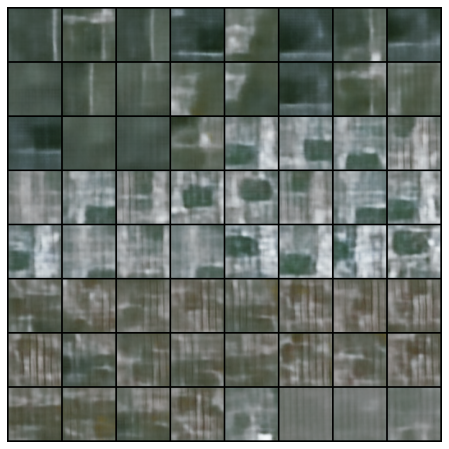

In [16]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.axis("off")
ax.imshow(vutils.make_grid(recon_imgs.detach().cpu(), normalize=False).permute(1,2,0))
plt.show()

In [17]:
fixed_noise = torch.randn(8, latent_dim//2, 1, 1, device=device)
noise_demo = []
for step, (_, _, demo) in enumerate(test_loader):
    if step == 0:
        noise_demo.append(demo[[0,20,40,60]][:,demo_cols])
    if step == 1:
        noise_demo.append(demo[[20,40,60]][:,demo_cols])
    if step == 2:
        noise_demo.append(demo[[20]][:,demo_cols])
        break
noise_demo = torch.cat(noise_demo, 0).to(device)
noise_demo = noise_demo[:,:,None,None]

# row: same demo vector, different noise vectors
# column: same noise vector, different demo vectors
fixed_noise = torch.cat([fixed_noise.repeat(8,1,1,1),noise_demo.repeat_interleave(8, dim=0)], axis=1)


In [18]:
sample_img = model.decoder(fixed_noise)


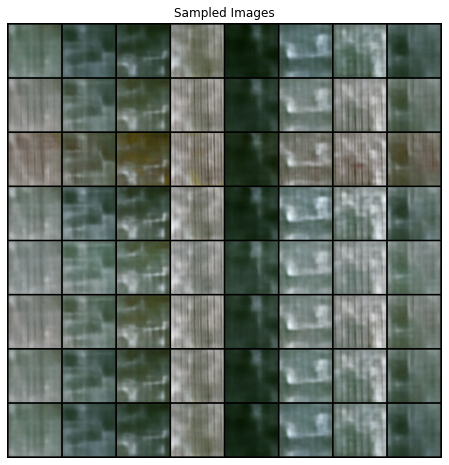

In [20]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.axis("off")
ax.set_title("Sampled Images")
ax.imshow(np.transpose(torchvision.utils.make_grid(sample_img, padding=2, normalize=True).cpu(),(1,2,0)));
